In [1]:
include("../scripts/kf.jl")

draw (generic function with 8 methods)

In [2]:
mutable struct EstimatedLandmark <: AbstractLandmark
    pos
    id
    cov
end

In [3]:
function EstimatedLandmark_()
    self = EstimatedLandmark(ntuple(x->nothing, fieldcount(EstimatedLandmark))...)
    self.pos = [0.0, 0.0]
    self.id = nothing
    self.cov = nothing
    return self
end

EstimatedLandmark_ (generic function with 1 method)

In [4]:
function draw(self::EstimatedLandmark, ax, elems)
    if isnothing(self.cov)
        return
    end
    
    c = ax.scatter(self.pos[1], self.pos[2], s=100, marker="*", label="landmarks", color="blue")
    elems = vcat(elems, c)
    elems = vcat(elems, ax.text( self.pos[1], self.pos[2] , string("id:", string(self.id)), fontsize=10))
    
    e = sigma_ellipse(self.pos, self.cov, 3)
    elems = vcat(elems, [ax.add_patch(e)])

end

draw (generic function with 9 methods)

In [5]:
mutable struct MapParticle <: AbstractParticle
    pose
    weight
    map
end

In [6]:
function MapParticle_(init_pose, weight, landmark_num)
    self = MapParticle(ntuple(x->nothing, fieldcount(MapParticle))...)
    self.pose = init_pose
    self.weight = weight
    self.map = Map()
    
    for i in 1:landmark_num
        append_landmark(self.map, EstimatedLandmark_())
    end
    return self
end

MapParticle_ (generic function with 1 method)

In [7]:
function init_landmark_estimation(self::MapParticle, landmark, z, distance_dev_rate, direction_dev)
    landmark.pos = z[1] * [cos(self.pose[3] + z[2]), sin(self.pose[3] + z[2])] + self.pose[1:2]
    H = matH(self.pose, landmark.pos)[1:2, 1:2]
    Q = matQ(distance_dev_rate*z[1], direction_dev)
    landmark.cov = inv(H'*inv(Q)*H)
end

init_landmark_estimation (generic function with 1 method)

In [8]:
function observation_update(self::MapParticle, observation, distance_dev_rate, direction_dev)
    for d in observation
        z = d[1]
        landmark = self.map.landmarks[d[2] + 1] #1indexed
        if isnothing(landmark.cov)
            init_landmark_estimation(self, landmark, z, distance_dev_rate, direction_dev)
        else
            observation_update_landmark(self, landmark, z, distance_dev_rate, direction_dev)
        end
    end
end

observation_update (generic function with 4 methods)

In [10]:
function observation_update_landmark(self::MapParticle, landmark, z, distance_dev_rate, direction_dev)
    estm_z = relative_polar_pos(IdealCamera(), self.pose, landmark.pos)
    if estm_z[1] < 0.01
        return
    end
    H = - matH(self.pose, landmark.pos)[1:2, 1:2]
    Q = matQ(distance_dev_rate*estm_z[1], direction_dev)
    K = landmark.cov * H' *(inv(Q+H*landmark.cov*H'))
    
    Q_z = H*landmark.cov*H' + Q
    self.weight *= pdf(MvNormal(estm_z, Symmetric(Q_z)), z)
    
    landmark.pos = K*(z-estm_z) + landmark.pos
    landmark.cov = (Matrix{Float64}(I, 2, 2) - K * H )*landmark.cov
end

observation_update_landmark (generic function with 1 method)

In [45]:
function drawing_params(self::MapParticle, hat_x, landmark, distance_dev_rate, direction_dev)
    ell = hypot((hat_x[1:2]-landmark.pos)...)
    Qhat_zt = matQ(distance_dev_rate*ell, direction_dev)
    hat_zt = relative_polar_pos(IdealCamera(), hat_x, landmark.pos)
    H_m = -matH(hat_x, landmark.pos)[1:2, 1:2]
    H_xt = matH(hat_x, landmark.pos)
    
    Q_zt = H_m*landmark.cov*H_m' + Qhat_zt
    return hat_zt, Q_zt, H_xt
end

drawing_params (generic function with 2 methods)

In [46]:
function gauss_for_drawing(self::MapParticle, hat_x, R_t, z, landmark,distance_dev_rate, direction_dev)
    hat_zt, Q_zt, H_xt = drawing_params(self, hat_x, landmark, distance_dev_rate, direction_dev)
    K = R_t * H_xt' * (inv(Q_zt + H_xt*R_t*H_xt'))
    return K*(z-hat_zt) + hat_x, (Matrix{Float64}(I, 3, 3) - K * H_xt ) * R_t
end

gauss_for_drawing (generic function with 2 methods)

In [69]:
function motion_update2(self::MapParticle, nu, omega, time, motion_noise_stds, 
        observation, distance_dev_rate, direction_dev)
    M = matM(nu, omega, time, motion_noise_stds)
    A = matA(nu, omega, time, self.pose[3])
    R_t = A*M*A'
    hat_x = state_transition(IdealRobot(), nu, omega, time, self.pose)
    
    for d in observation
        hat_x, R_t = gauss_for_drawing(self, hat_x, R_t, d[1], self.map.landmarks[d[2]+1],
                                distance_dev_rate, direction_dev)
    end
    self.pose = rand(MvNormal(hat_x, Symmetric(R_t+Matrix{Float64}(I, 3, 3)*1.0e-10)))
end

motion_update2 (generic function with 2 methods)

In [70]:
mutable struct FastSlam <: AbstractMcl
    particles
    map
    distance_dev_rate
    direction_dev
    motion_noise_rate_pdf
    ml
    pose
    motion_noise_stds
end

In [71]:
function FastSlam_(init_pose, particle_num, landmark_num, motion_noise_stds=Dict("nn"=>0.19, "no"=>0.001, "on"=>0.13, "oo"=>0.2),
        distance_dev_rate=0.14, direction_dev=0.05)
    self = FastSlam(ntuple(x->nothing, fieldcount(FastSlam))...)
    self.particles =[Particle(init_pose, 1.0/particle_num) for i in 1:particle_num]
    self.map = nothing
    self.distance_dev_rate = distance_dev_rate
    self.direction_dev = direction_dev
    v = motion_noise_stds
    c = Diagonal([v["nn"]^2, v["no"]^2, v["on"]^2, v["oo"]^2])
    self.motion_noise_rate_pdf = MvNormal(zeros(4), c)
    self.ml = self.particles[1]
    self.pose = self.ml.pose
    
    self.particles = [MapParticle_(init_pose, 1.0/particle_num, landmark_num) for i in 1:particle_num]
    self.ml = self.particles[1]
    
    self.motion_noise_stds = motion_noise_stds
    return self
end

FastSlam_ (generic function with 4 methods)

In [72]:
function observation_update(self::FastSlam, observation)
    for p in self.particles
        observation_update(p, observation, self.distance_dev_rate, self.direction_dev)
    end
    set_ml(self)
    resampling(self)
end

observation_update (generic function with 5 methods)

In [73]:
function motion_update(self::FastSlam, nu, omega, time, observation)
    not_first_obs = []
    for d in observation
        if !isnothing(self.particles[1].map.landmarks[d[2] + 1].cov)
            push!(not_first_obs, d)
        end
    end
    
    if length(not_first_obs) > 0
        for p in self.particles
            motion_update2(p, nu, omega, time, self.motion_noise_stds, not_first_obs,
                                            self.distance_dev_rate, self.direction_dev)
        end
    else
        for p in self.particles
            motion_update(p, nu, omega, time, self.motion_noise_rate_pdf)
        end
    end
end

motion_update (generic function with 4 methods)

In [74]:
function draw(self::FastSlam, ax, elems)
    xs = [p.pose[1] for p in self.particles]
    ys = [p.pose[2] for p in self.particles]
    vxs = [cos(p.pose[3])*p.weight*length(self.particles) for p in self.particles]
    vys = [sin(p.pose[3])*p.weight*length(self.particles) for p in self.particles]
    elems = vcat(elems, ax.quiver(xs, ys, vxs, vys, angles="xy", scale_units="xy", color="blue", alpha=0.5))
    draw(self.ml.map, ax, elems)
end

draw (generic function with 10 methods)

In [75]:
mutable struct FastSlam2Agent <: AbstractEstimationAgent
    nu
    omega
    estimator
    time_interval
    prev_nu
    prev_omega
end

In [76]:
function  FastSlam2Agent_(time_interval, nu, omega,estimator)
    self = FastSlam2Agent(ntuple(x->nothing, fieldcount(FastSlam2Agent))...)
    self.nu = nu
    self.omega = omega
    self.estimator = estimator
    self.time_interval = time_interval
    self.prev_nu = 0.0
    self.prev_omega = 0.0
    return self
end

FastSlam2Agent_ (generic function with 1 method)

In [77]:
function decision(self::FastSlam2Agent, observation=nothing)
    motion_update(self.estimator, self.prev_nu, self.prev_omega, self.time_interval, observation)
    self.prev_nu, self.prev_omega = self.nu, self.omega
    observation_update(self.estimator,observation)
    return self.nu, self.omega
end

decision (generic function with 6 methods)

In [78]:
function trial()
    time_interval = 1.0
    world = World_(30, time_interval, false)
    
    m = Map()
    for ln in [[-4.0, 2.0], [2.0, -3.0], [3.0, 3.0]]
        append_landmark(m, Landmark(ln))
    end
    append(world, m)
    
    initial_pose = [0.0, 0.0, 0.0]
    pf = FastSlam_(initial_pose, 100, length(m.landmarks))
    a = FastSlam2Agent_(time_interval, 0.2, 10.0/180*pi, pf)
    r = Robot_(initial_pose, sensor=Camera_(m), agent=a, color="red")
    append(world, r)
    draw(world)
    showanim("test.mp4")
end

trial (generic function with 1 method)

<video controls src="data:video/x-m4v;base64,AAAAIGZ0eXBpc29tAAACAGlzb21pc28yYXZjMW1wNDEAAAAIZnJlZQABdd5tZGF0AAACoAYF//+c3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE1NyAtIEguMjY0L01QRUctNCBBVkMgY29kZWMgLSBDb3B5bGVmdCAyMDAzLTIwMTggLSBodHRwOi8vd3d3LnZpZGVvbGFuLm9yZy94MjY0Lmh0bWwgLSBvcHRpb25zOiBjYWJhYz0xIHJlZj0zIGRlYmxvY2s9MTowOjAgYW5hbHlzZT0weDM6MHgxMTMgbWU9aGV4IHN1Ym1lPTcgcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhlZF9yZWY9MSBtZV9yYW5nZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTEgOHg4ZGN0PTEgY3FtPTAgZGVhZHpvbmU9MjEsMTEgZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz0xMiBsb29rYWhlYWRfdGhyZWFkcz0yIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFjZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJhbWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdlaWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MSBzY2VuZWN1dD00MCBpbnRyYV9yZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0wLjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAAKHhliIQAF//+99S3zLLtU2+2C6j3op4mX0N1JQGblsTtOoAAAAMAAAMAAB68FzgCX4kK868AAAMAyoAXqEn/CmOPiA7BC5NJlvfhKIWPSXi/zA6JYDLoQAMQkginty7NGv2twoUk3+x++sOjYLO23GkLnX3zZEYn6a9vQcRQLf67K7SBvVrJ/o4DfjcfmL80ItpTpOBk9UoqIRYyXX9Jp26SG/qkhzXvDYJnUDUkXMWTV9xgIkId/B0DL63tzWtJoDT3qBLshsubVeON8CDX6ibsLgVVQ4A0D7tGbVkDzT/KsUAH7fA8ber7HvEJfThyzrLkSWNw9QjQzXk0jYHioNxDFOC0u5P/6flbarG27qxKpcR1g3jAe/uyNQkdibir9L1oZNoxCL9nTz5Do7WCxbfdwBz786P6Gt3+a9qFmQoe2Qlbs6zkxnOY8FmvubMXtnqJ20rtvpHrl79t6nq8q+9ZGR6BdRh00t3Aigy2K6jkGX8xF2NbE0107yMuMhNJ8nLf3bEUDA1W0TIui6TwnLCPxsZoeNH9a4AHuu+fRe2d9XIIXx50n+Od5GeJI+w65vIpFM505Ok+93xmUtuVHGQ3eacRH3D3LWgvRa8VlJf0rW/lw3pNMKrLBfC42qBBbPPf9t2q9s/FQBF+eHBqb/CB1m4Za8y+nnzp4tqwGv7FWpgi0iuEQ4W59KBcdz8U2ukqDc8XRyHIGUzQWrN2B2hH41jBxiu8GM2/yYQASZZNk6cnN992hxnRVU/+oJK/JdfpqQC09Qp+0lkF/MADsjxgxnmkyiD4cJFbjyc/bIvgLZswUinp9mbC+OqS+B3Ka9nIBrRd8URZmZnmnn6jGyox4iNCMwrJzVTMejzVjwcpF5gWSDBAd3fPNh4CYMsOqHHJJ1HIr3/3KzKyJnKGIPwD1EjEsKeZY5DEKBN4Lbx26JgmuTA0OP3RbWAeL+irUAAdvximab6tYtmIDtSY3U913HQxRgmhp/597w3yfZ52GLUciYxAXWl/cWNdO3OLelzk/jyowoJf3B3AMMnRPbQ6GhaPpBASX0ILIG7R4/0xLCQjBxlUT3CimocEIxmJUPZlbmjhLpMPHusqLfYflfm4QdMfP9YjfKwPhfjMMgxiOs7U/9D4UGDL1wOjjCNTYuDEYeBo6bdGA7/i1vKjrit41TKQtj20w0RkNODbL8NFkTwuIyanPmtTrrHmb0gmnIw/lYIrqpi5Ll7GiO/tACMXPEKqHFekrwq1CSDBiE5kVDiFeStW/E3U9Lirw3H4emOvW8gy1yQbt7D9RrWOagLa18R7Dc57tDUY+iOVUvXt4C+WwLvaxbaOCbollVV7pgKjcKyCVA1tTS78kgvfuglYh064dAN3SQwBNEO3F+AqvlWXbO2Ij3nKMj8e0ZDSB5PWRZyTFUXno/zY3o5PX9lkXJZ6YPpS4O5T5SCpEdT+n6aDBKsN0W0hm+ulIGmv41upv4C13A+Slbw8nFag7ocYYIbc/yXku7k2APxgDa880CnIvyhfJU65DRtgJS1CDdPldG/vbCKhcWqxqvEVo0S4AU+xF5xBQmhn7Y6sbWBEx0D4gJxrE7an0+vnep7uWE+hYyZc8nBTxKpuxh7nUTcZXMnuWnIUzB8zdJsT1REJb/781WsO2dkzVcV/gSB7nTJTixbxjdkCpctWZApjTr81W5nNDejIfAr+wJ5gNCVWBNcB0xYxxrp4wfgX2TIVoDlJ5i7hG3OxtP+w0793KE+6KPDskTCitrUpcEFRhZMH1DZbXx/r136Aa+76bjdCqAVFEvuur8R+UHTMFL7C7nQ+yBHWBL8irGPUTDhekZqBYe8Ex81fcLAMts8McLG/me/5H0WQorJo73+jhVjaeDkNXoi6QWEI6hSCAGG4OD6PNwSeT4bj2sPIksc27RXvvEH67fSkZ9O+ukePett35NlCd/LvlqAUK7ng9JP1ZmgQJygjfyS1ekgsZUelxxRZUfG+OJqARYDqW1r3giiCKGo4T+P9We8vcae6SGcRt+A6I5Ea/Bex9vZYNopXstsAWh4AcUGEPfpKl2/Ebhst4ypHb/QdMhbhPsjxjSQZP8VEKn418q7xVJ6qn+cM8Cx9qrwmTYDckTo8En9z0FxMYXeHlTLLKaS3KZl9TV6XPgN6DvtJVslLmFtUY4ykiP4VGbipHSU6z/CM0ZCSaRA1B4ibiYo0l/167zXihGpnItx0N9VdXtW5K/UxyAMxeK4NeYFeKaJQE6kFs8ijGQ1qVTuEih86E8aIxAS7emXv8pvSrnuPPfERmeEtqg70jQ6xvRUt/KiY6HeDls58q39fDekwQOA+xTSGT8PJXym5vgrhgEnSprBZm+GOmHb9esjc8a6HPnBOD/8obbe7tKFthRxf2fjXHMbP+Dj9TXPrmLPi35FR8JjkZM+5MhqXq0TNB4R2iAuhzJ813c1VSj/YfUhixygA/p3bse6mkeOVTFcil10JtsMNWKb4ND3ByBDfxxan4tql5B6SduxCJuU0NNfVhnuqbU2bJk7Rtax93nrdvp6OSTGEZzOER0Cs3qnf7lhMoSfxMDWdfPUaxW4vjYd+f1i5VW1XAAiqsIePJgIaySVB8UIDj2g6TSJwaqTceE9hJJvcCf6bYZT6S2wDiXDaX94bRdm11HPws1B6vxvV1uP/EKiegWrHLXFK9ZckXn5n9S6HM+sN0tEA0jKYWZN/6WbctKplE+/Q9qoR8P7Pbvpcld+HVmNTPEhEm1z8oeGEl6eTgWVtM9jdh/Sr2ohW9cAx+ZUwdvqPPhCnCpuhTYehDOxi4cHwoyfEZHeGKdJw1PZ1boY9oNbfeGaQAhDb4/FQvh5UGfF1Hw7WRul4Qq7De/binkyeD6nEAoBsTrwZJN5tww9WgruSjsKOZNObzRgHb08bvhScT829MRdfUpGCH+yMvsV4hYgMEZsrz747lHRsVGZqCqK3jXVK7HnVClMIDHNnuR6TTPlVMGS

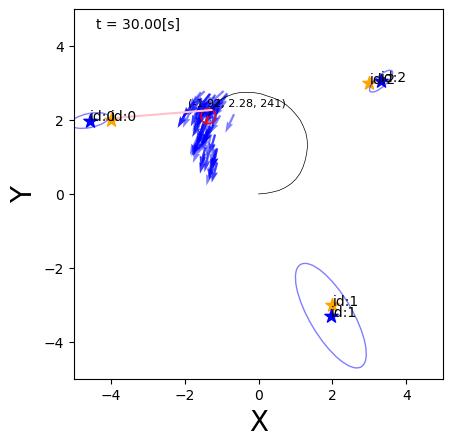

In [79]:
trial()